# BOND DURATION

author: [@sparshsah](https://github.com/sparshsah)


My point here is to show that (a) You don't have to be super-clever with duration-calcs to get close to the reality (although I'm not sure how accurately my calc reflects the effects of convexity), and (b) What people mean when they compain about a "mark-to-market hit" on a private-bond book unhedged to rate hikes.

See [the Investopedia article on duration and convexity](https://www.investopedia.com/articles/bonds/08/duration-convexity.asp) for more info.

In [40]:
from __future__ import annotations

from typing import Final

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import foggy_statslib.core as fc
import foggy_statslib.fin as ff

In [47]:
# ignores yield-curve term structure
DISCOUNT_R: Final[float] = 0.05
RATE_HIKE: Final[float] = 0.01
TERMS: Final[list[int]] = [1, 2, 5, 10, 15, 20, 30]

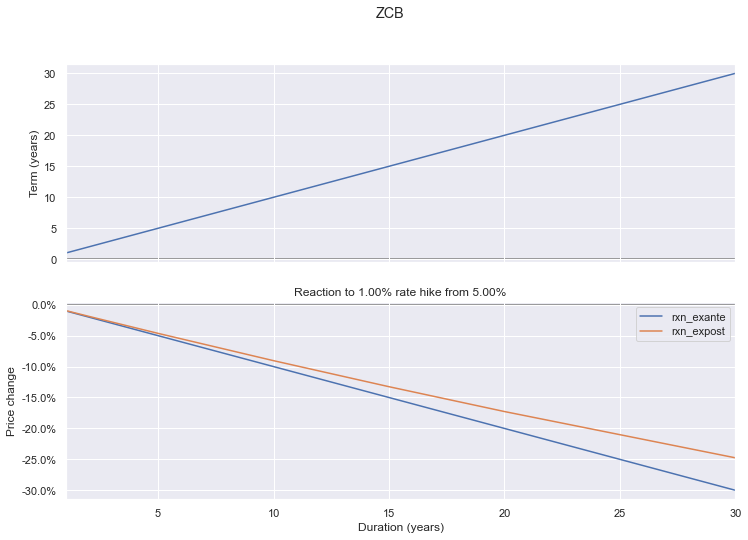

In [48]:
def _get_zcb_fv(term: float = 1) -> pd.Series:
    """Get cashflow stream of a zero-coupon govie."""
    return pd.Series({term: 1})

def _get_zcb_dur_and_rxn(term: float = 1) -> pd.Series:
    """Get duration pre-hike and reaction (price change %) to hike.
    
    I was too lazy to code the actual duration formula, but this is close enough.
    """
    fv = _get_zcb_fv(term=term)
    dur = ff._get_dur(fv=fv, discount_r=DISCOUNT_R)
    rxn_exante = - dur * RATE_HIKE
    pv_pre = ff._get_pv(fv=fv, discount_r=DISCOUNT_R).sum()
    pv_post = ff._get_pv(fv=fv, discount_r=DISCOUNT_R + RATE_HIKE).sum()
    rxn_expost = pv_post / pv_pre - 1
    return pd.Series({"dur": dur, "rxn_exante": rxn_exante, "rxn_expost": rxn_expost})

def get_zcb_dur_and_rxns() -> pd.DataFrame:
    return pd.DataFrame(
        {
            term:
            _get_zcb_dur_and_rxn(term=term)
            for term in TERMS
        }
    ).T


df = get_zcb_dur_and_rxns()
_, ax = plt.subplots(nrows=2, sharex=True)
fc.plot(
    pd.Series(data=df["dur"].values, index=df["dur"].index),
    xlabel="Duration (years)",
    ylabel="Term (years)",
    ax=ax[0],
)
fc.plot(
    df[["rxn_exante", "rxn_expost"]],
    xlabel="Duration (years)",
    ylabel="Price change",
    ypct=True,
    title=f"Reaction to {RATE_HIKE *100 :.2f}% rate hike from {DISCOUNT_R *100 :.2f}%",
    ax=ax[1],
)
plt.suptitle("ZCB")
plt.show()

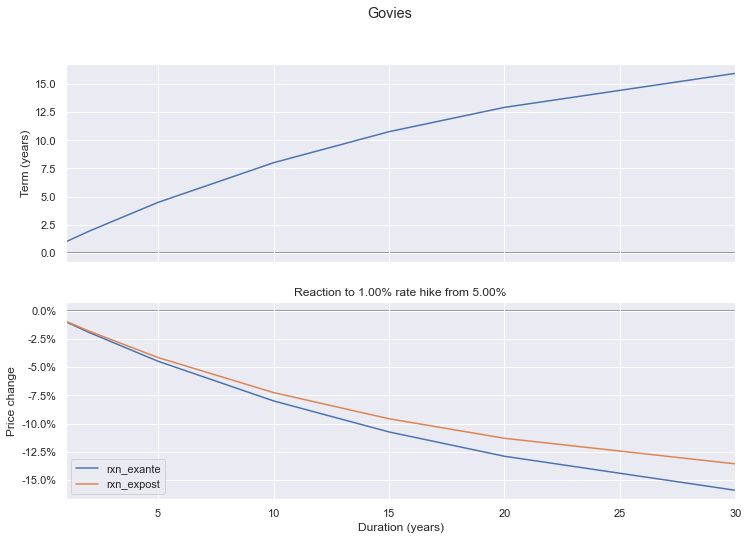

In [49]:
def _get_govie_fv(term: float = 1) -> pd.Series:
    """Get cashflow stream of a coupon-paying govie."""
    # coupon paid every 6mos
    coupon_ts = np.linspace(0.50, term, num=term*2)
    semiannual_coupon = DISCOUNT_R / 2
    fv = pd.Series({t: semiannual_coupon for t in coupon_ts})
    fv.iloc[-1] = fv.iloc[-1] + 1
    return fv

def _get_govie_dur_and_rxn(term: float = 1) -> pd.DataFrame:
    """Get duration pre-hike and reaction (price change %) to hike.
    
    I was too lazy to code the actual duration formula, but this is close enough.
    """
    fv = _get_govie_fv(term=term)
    dur = ff._get_dur(fv=fv, discount_r=DISCOUNT_R)
    rxn_exante = - dur * RATE_HIKE
    pv_pre = ff._get_pv(fv=fv, discount_r=DISCOUNT_R).sum()
    pv_post = ff._get_pv(fv=fv, discount_r=DISCOUNT_R + RATE_HIKE).sum()
    rxn_expost = pv_post / pv_pre - 1
    return pd.Series({"dur": dur, "rxn_exante": rxn_exante, "rxn_expost": rxn_expost})

def get_govie_dur_and_rxns() -> pd.DataFrame:
    return pd.DataFrame(
        {
            term:
            _get_govie_dur_and_rxn(term=term)
            for term in TERMS
        }
    ).T


df = get_govie_dur_and_rxns()
_, ax = plt.subplots(nrows=2, sharex=True)
fc.plot(
    pd.Series(data=df["dur"].values, index=df["dur"].index),
    xlabel="Duration (years)",
    ylabel="Term (years)",
    ax=ax[0],
)
fc.plot(
    df[["rxn_exante", "rxn_expost"]],
    xlabel="Duration (years)",
    ylabel="Price change",
    ypct=True,
    title=f"Reaction to {RATE_HIKE *100 :.2f}% rate hike from {DISCOUNT_R *100 :.2f}%",
    ax=ax[1],
)
plt.suptitle("Govies")
plt.show()

In [50]:
df["rxn_expost"] / df["rxn_exante"]

1     0.943424
2     0.939083
5     0.926655
10    0.907835
15    0.891231
20    0.876668
30    0.852956
dtype: float64